# Mother Machine Data Pipeline for Symbiodinium cells

## Prerequsities: 
- your raw data is in tiff-file format (can be converted with eg. bioformats)
- you (manually) create a folder on your computer where you want to store all your results

### Import packages

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from PIL import Image
import imageio
import io
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
import warnings
import tifffile

import skimage
from skimage import io 
from skimage import io as skio, measure, segmentation, color
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.util import img_as_float, img_as_ubyte
from skimage.io import imread, imsave

import napari
from tqdm.notebook import tqdm 
import pandas as pd

import cellpose.models
from cellpose import io as cellpose_io

#from deepcell_tracking import CellTracker


C:\Users\micha\anaconda3\anaconda_file\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Define filepaths and create directories

In [46]:
"""INPUT PATH TO FOLDER YOU WANT OUTPUTS TO BE IN"""
output_folder = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all"


"""INPUT FILE PATH TO RAW-DATA TIFF-FILE"""
original_tiff_image_series = r"C:\Users\micha\Desktop\Master_Project\ORIGINAL_TIFF_Series_rawdata\new_data\converted_Z1.tiff"


#CREATE FOLDER WHERE ALL RESULTS FROM SPECIFIC RAW-DATA TIFF FILE TO SAVE
base_name = os.path.splitext(os.path.basename(original_tiff_image_series))[0]
result_folder = os.path.join(output_folder, f"MM_pipeline_results_{base_name}")
os.makedirs(result_folder, exist_ok=True)
print(f"Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: {result_folder}")


#CREATE DIRECTORY TO SAVE THE CROPPED TRAPS IN
cropped_traps_output_dir = os.path.join(result_folder, "Cropped_traps_directory")
os.makedirs(cropped_traps_output_dir, exist_ok=True)


#CREATE DIRECTORY TO SAVE SEGMENTATION LABELS IN
labels_directory = Path(os.path.join(result_folder, "Labels_directory"))
labels_directory.mkdir(exist_ok=True)


#READ IMAGES INTO PYTHON AND ROTATE THEM 
original_image_series = tifffile.imread(original_tiff_image_series)
rotated_image_series = np.rot90(original_image_series, k=-1, axes=(2, 3))


Pipeline results for this specific TIFF-file (raw data) will be saved in the directory: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_converted_Z1


### View the image series in Napari (rotated 90 degrees right)
View your raw tiff image file in Napari to make sure it looks good

In [47]:
print("Original shape:", original_image_series.shape)

viewer = napari.Viewer()

#viewer.add_image(rotated_image_series, name= 'new data')
num_channels = rotated_image_series.shape[1]
for channel in range(num_channels):
    if channel == 1:
        # Preserve color for the red fluorescence channel
        viewer.add_image(rotated_image_series[:, channel, :, :], colormap='red', name=f'Red Fluorescence')
    else:
        # Convert other channels to grayscale
        viewer.add_image(rotated_image_series[:, channel, :, :], colormap='gray', name=f'Channel {channel + 1}')
    
print("Rotated shape:", rotated_image_series.shape)


"""
viewer = napari.view_image(
        cells,
        channel_axis=1,
        name=["membrane", "nuclei"],
        colormap=["green", "magenta"],
        contrast_limits=[[1000, 20000], [1000, 50000]],
        )
        """

Original shape: (275, 2, 2044, 2048)
Rotated shape: (275, 2, 2048, 2044)


'\nviewer = napari.view_image(\n        cells,\n        channel_axis=1,\n        name=["membrane", "nuclei"],\n        colormap=["green", "magenta"],\n        contrast_limits=[[1000, 20000], [1000, 50000]],\n        )\n        '

### Manual cropping of growth traps/channels for each image 
Manually draw boxes around traps (first frame of the tiff file), the coordinates for these will be saved and then used to crop all subsequent traps

In [4]:
matplotlib.use('Qt5Agg')  # Use 'Qt5Agg' backend

class ManualTrapCropping:
    def __init__(self, image_data, channel_index):
        self.image = image_data[channel_index]
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.image, cmap='gray')  # Display the image as grayscale
        self.rectangles = {}
        self.current_trap_index = 1
        self.first_rect_coords = None
        self.fixed_size = None
        self.rs = RectangleSelector(self.ax, self.on_rectangle_select,
                                     minspanx=5, minspany=5, spancoords='pixels', interactive=True)
        plt.connect('key_press_event', self.on_key_press)

    def on_rectangle_select(self, eclick, erelease):
        if self.fixed_size is None:
            # Store the dimensions of the first rectangle
            self.fixed_size = (erelease.xdata - eclick.xdata, erelease.ydata - eclick.ydata)

        # Use the fixed size for subsequent rectangles
        x_min, y_min = eclick.xdata, eclick.ydata
        x_max, y_max = x_min + self.fixed_size[0], y_min + self.fixed_size[1]

        # Save the rectangle coordinates globally
        global trap_coordinates_dict
        trap_coordinates_dict[self.current_trap_index] = (x_min, y_min, x_max, y_max)

    def on_key_press(self, event):
        if event.key == 'enter':
            # Draw the rectangle on the plot
            rect_coords = trap_coordinates_dict[self.current_trap_index]
            x_min, y_min, x_max, y_max = rect_coords
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            self.ax.add_patch(rect)
            plt.draw()

            # Increment the trap index for the next rectangle
            self.current_trap_index += 1

        elif event.key == 'q':
            # Print the final dictionary of rectangles
            print("Trap coordinates:", trap_coordinates_dict)
            plt.close()

# Initialize the dictionary globally
trap_coordinates_dict = {}

# Specify the channel index you want to crop
channel_index_to_crop = 0  # Adjust this to the desired channel index

# Create an instance of ManualTrapCropping
manual_cropping = ManualTrapCropping(rotated_image_series[0], channel_index_to_crop)
plt.show()


Trap coordinates: {1: (41.293999104343584, 7.0665024630543485, 293.51074787281664, 2041.997089117779), 2: (302.10904612628724, 4.200403045230814, 554.3257948947603, 2039.1309896999555), 3: (1686.4350649350652, 7.0665024630543485, 1938.6518137035382, 2041.997089117779)}



KeyboardInterrupt



### Print height and width for each trap:

In [5]:
def calculate_rectangle_size(trap_coordinates_dict):
    sizes = {}

    for trap_index, coord in trap_coordinates_dict.items():
        x1, y1, x2, y2 = coord
        width = x2 - x1
        height = y2 - y1
        sizes[trap_index] = {'width': width, 'height': height}

    return sizes

# Example usage
rectangle_sizes = calculate_rectangle_size(trap_coordinates_dict)

for trap_index, size in rectangle_sizes.items():
    print(f"Trap {trap_index} Size: Width = {size['width']}, Height = {size['height']}")


Trap 1 Size: Width = 252.21674876847305, Height = 2034.9305866547247
Trap 2 Size: Width = 252.21674876847305, Height = 2034.9305866547247
Trap 3 Size: Width = 252.21674876847305, Height = 2034.9305866547247


### Visualisation of cropped traps
Visualises cropped traps for first and last frame 
- Check first and last frame to assess shifts in X and Y

In [25]:
%matplotlib widget
import matplotlib.pyplot as plt

def crop_visualise_image(image_data, trap_coordinates_dict, channel_index):
    # Create subplots to display the original and cropped traps
    num_traps = len(trap_coordinates_dict)
    fig, axes = plt.subplots(1, num_traps + 1, figsize=(15, 5), squeeze=False)

    # Display the original image in grayscale
    original_channel = image_data[channel_index]
    axes[0, 0].imshow(original_channel, cmap='gray') 
    axes[0, 0].set_title("Original Image")

    # Crop the image based on the rectangles and display each cropped trap
    for i, (trap_index, rect_coords) in enumerate(trap_coordinates_dict.items(), start=1):
        x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values
    
        # Ensure coordinates are within the image boundaries
        x_min = max(0, x_min)
        x_max = min(original_channel.shape[1], x_max)
        y_min = max(0, y_min)
        y_max = min(original_channel.shape[0], y_max)
    
        # Crop the image
        cropped_trap = original_channel[y_min:y_max, x_min:x_max]
    
        # Display the cropped trap in grayscale
        axes[0, i].imshow(cropped_trap, cmap='gray', extent=(x_min, x_max, y_max, y_min))
        axes[0, i].set_title(f"Cropped Trap {trap_index}")

    plt.show()

# Example usage with trap_coordinates_dict and channel_index
channel_index_to_crop = 0 # Adjust this to the desired channel index
crop_visualise_image(rotated_image_series[0], trap_coordinates_dict, channel_index_to_crop)
crop_visualise_image(rotated_image_series[-1], trap_coordinates_dict, channel_index_to_crop)


NameError: name 'rotated_image_series' is not defined

### Crop the traps and save them as tiff-files (4D numpy-arrays (CTYX)) one for each trap
Crops the traps based on the manual selection and saves each trap in different folders which correspond to trap position 

In [7]:

# Define empty arrays
shape_minmax_list= []
cropped_traps_list = []
cropped_traps_dict = {}
# Loop to crop each trap
for trap_index, rect_coords in trap_coordinates_dict.items():
    x_min, y_min, x_max, y_max = map(int, rect_coords)  # Ensure integer values

    #Ensure trap-coordinates are within the image boundaries
    x_min = max(0, x_min)
    x_max = min(rotated_image_series.shape[-1], x_max)
    y_min = max(0, y_min)
    y_max = min(rotated_image_series.shape[-2], y_max)

    # Crop the image series
    cropped_trap = rotated_image_series[:, :, y_min:y_max, x_min:x_max]

    cropped_traps_dict[trap_index] = cropped_trap

    #add trap X&Y to list
    shape_minmax_list.append((cropped_trap.shape[-1], cropped_trap.shape[-2]))

# Find the maximum values for the first and second elements
transposed_list = list(zip(*shape_minmax_list))
max_X = max(transposed_list[0])
max_Y= max(transposed_list[1])


#for loop to save padded traps in array
for trap_index, cropped_trap in tqdm(cropped_traps_dict.items(), desc="Processing Traps", unit="trap"):
    #calculate padding based on max X&Y
    columns_to_pad = max(0, int(max_X) - cropped_trap.shape[-1])  # Pad along the last dimension (width/X)
    rows_to_pad = max(0, int(max_Y) - cropped_trap.shape[-2])  # Pad along the second-to-last dimension (height/Y)
    
    if columns_to_pad > 0 or rows_to_pad > 0:
        padded_trap = np.pad(cropped_trap, ((0, 0), (0, 0), (0, rows_to_pad), (0, columns_to_pad)), mode='constant', constant_values=0)
    else:
        padded_trap = cropped_trap

    cropped_traps_filename = f"trap_{trap_index}_all_frames_series.tiff"
    cropped_traps_filepath = os.path.join(cropped_traps_output_dir, cropped_traps_filename)
    io.imsave(cropped_traps_filepath, padded_trap)




Processing Traps:   0%|          | 0/3 [00:00<?, ?trap/s]

### View the resulting cropped-trap tiff-files in Napari 
Specify which trap-series to view in the variable "trap_number_to_view"

In [8]:
trap_number_to_view = 1  # Change this to the desired trap number

In [9]:
import napari
from skimage import io as skio
from pathlib import Path

def load_trap_series(trap_number):
    # Construct the file path based on the trap number
    file_path = os.path.join(cropped_traps_output_dir, "trap_{}_all_frames_series.tiff".format(trap_number))
    
    # Read the tiff file
    tiff_stack = skio.imread(file_path)
    print(tiff_stack.shape)
    return tiff_stack

# Load the tiff stack for the specified trap
trap_stack = load_trap_series(trap_number_to_view)

# Open Napari viewer
viewer = napari.Viewer()

# Add the tiff stack as a 3D layer
viewer.add_image(trap_stack, name=f'Trap {trap_number_to_view} - All Frames Series', colormap='gray')

# Start the Napari viewer
napari.run()


(275, 2, 2035, 252)


### Parameters for the cellpose model as well as for filtering labels post segemenation

In [17]:
"""DEFINE CELLPOSE MODEL AND IF YOU HAVE GPU"""
model = models.Cellpose(gpu=False, model_type='cyto2')


"""PARAMETERS FOR THE CELLPOSE MODEL"""
custom_params_segmentation = {
    'diameter': 80.0,
    'interp': 'lanczos3',
    'cellprob_threshold': 0.1,
    'flow_threshold': 0.4,
    'min_size': 500
}


### CELLPOSE on entire image series and saving labels in Labels_directory

In [8]:
import numpy as np
from cellpose import models, io
from skimage import io as skio, measure
import os
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

# Define the input directory for the TIFF files of cropped traps
img_dir = cropped_traps_output_dir

# List all files in the input directory
files_traps_tiff = [f for f in os.listdir(img_dir) if f.endswith('.tiff')]

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto2')

# or if you have different types of channels in each image
channels = [[1, 1]]

warnings.filterwarnings("ignore")

# Loop through each tiff file and perform segmentation for all frames
for tiff_file_trap in files_traps_tiff:
    warnings.filterwarnings("ignore")

    # Convert the string filename to a Path object
    tiff_file_trap = Path(tiff_file_trap)

    # Construct the full path to the trap_tiff file
    tiff_path_trap = os.path.join(img_dir, tiff_file_trap)

    # Read the trap_tiff image
    img_trap = io.imread(tiff_path_trap)

    # Create an empty array to store segmented masks for all frames
    masks_trap_all_frames = np.zeros_like(img_trap, dtype=np.uint16)

        # Loop through each frame in the trap_tiff file
    for frame_index, frame in tqdm(enumerate(img_trap), desc=f"Processing frames for {tiff_file_trap}", total=img_trap.shape[0], unit=" frames"):
        # Your existing code for processing each frame
            warnings.filterwarnings("ignore")
    
            # Perform cell segmentation for each frame
            masks_trap, _, _, _ = model.eval(frame, channels=channels, **custom_params_segmentation)
        
            # Save the unique cell labels for each frame
            labels_trap_frame = measure.label(masks_trap)
    
            # Accumulate the labels in a new 4D array
            masks_trap_all_frames[frame_index] = labels_trap_frame
            #strip channel dimension to make it 3D
            masks_3D_all_frames = masks_trap_all_frames[:, 0, :, :]
        
            # Save the 3D NumPy array as a single TIFF file in the labels_directory
            labels_file_trap = labels_directory / f"{tiff_file_trap.stem}_test.tiff"
            skio.imsave(labels_file_trap, masks_3D_all_frames.astype(np.uint16), plugin='tifffile')


100%|██████████| 550/550 [00:00<00:00, 665.37it/s]


Processing frames for trap_1_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

100%|██████████| 550/550 [00:01<00:00, 488.28it/s]


Processing frames for trap_2_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

100%|██████████| 550/550 [00:01<00:00, 490.99it/s]


Processing frames for trap_3_all_frames_series.tiff:   0%|          | 0/275 [00:00<?, ? frames/s]

### View labels and traps in Napari
Unfiltered!

In [3]:
"""PARAMETERS FOR FILTERING LABELS AFTER SEGMENTATION"""
# Filtering thresholds
min_area_threshold = 500
max_area_threshold = 12000


### Filter and visualize labels (filtered + unfiltered) on traps

In [36]:

croppedtrap_frames_list = []

original_files = sorted(Path(cropped_traps_output_dir).glob("*.tiff"))
original_image_file_paths = labels_file_paths = [str(file_path) for file_path in original_files]

#orginal frame layering: 
for frame_index in tqdm(range(len(tifffile.imread(labels_file_paths[0]))), desc="Processing Frames"):

    original_frames_for_timepoint = []

    for original_image_tiff in original_image_file_paths:
        original_image_array = tifffile.imread(original_image_tiff)[:, 0, :, :]
        original_frame = original_image_array[frame_index]
        
        original_frames_for_timepoint.append(original_frame)
        
    croppedtrap_stacked_frames_for_timepoint = np.vstack(original_frames_for_timepoint)
    croppedtrap_frames_list.append(croppedtrap_stacked_frames_for_timepoint) 


croppedtrap_frames_array = np.stack(croppedtrap_frames_list)



Processing Frames:   0%|          | 0/275 [00:00<?, ?it/s]

In [39]:
viewer = napari.Viewer()

viewer.add_image(croppedtrap_frames_array, name="Cropped Traps", scale=[1, 1, 1])

<Image layer 'Cropped Traps' at 0x26cccba3b50>

In [43]:
import numpy as np
from skimage import measure
import tifffile
import napari
from pathlib import Path
from scipy.ndimage import binary_dilation, binary_erosion


# Filtering function:
def filter_labels_function(labels, min_area_threshold, max_area_threshold):
    # Initialize an empty array to store the filtered labels
    filtered_labels = np.zeros_like(labels)
    for region in reversed(measure.regionprops(labels)):
        if min_area_threshold < region.area < max_area_threshold:
            #if condition is met, extract coords
            coords = region.coords
            #If condition is met change set to 1
            filtered_labels[coords[:, 0], coords[:, 1]] = region.label
            
    # Apply dilation + erosion to refine shapes (closing)
    filtered_labels = binary_dilation(filtered_labels, structure=np.ones((3, 3)))
    filtered_labels = binary_erosion(filtered_labels, structure=np.ones((3, 3)))

    return filtered_labels


# Load label files as 3D array
filtered_frames_list = []  # List to store individual filtered frames
unfiltered_frames_list = []  # List to store individual filtered frames


labels_files = sorted(Path(labels_directory).glob("*.tiff"))
labels_file_paths = [str(file_path) for file_path in labels_files]



# Iterate over frames for each time point and stack frames across files
for frame_index in tqdm(range(len(tifffile.imread(labels_file_paths[0]))), desc="Processing Frames"):
    
    #create empty lists to store data for time points:
    filtered_frames_for_timepoint = []  
    unfiltered_frames_for_timepoint = []    

    for label_tiff in labels_file_paths: 
        labels_array = tifffile.imread(label_tiff)
        frame = labels_array[frame_index]

               
        filtered_labels = filter_labels_function(frame, min_area_threshold, max_area_threshold)
        filtered_frames_for_timepoint.append(filtered_labels)
        
        unfiltered_frames_for_timepoint.append(frame)

    # Vertically stack frames for each time point across files (filtered labels)
    stacked_frames_for_timepoint = np.vstack(filtered_frames_for_timepoint)
    filtered_frames_list.append(stacked_frames_for_timepoint)
    
    #stack unfiltered labels
    unfiltered_stacked_frames_for_timepoint = np.vstack(unfiltered_frames_for_timepoint)
    unfiltered_frames_list.append(unfiltered_stacked_frames_for_timepoint)

# Combine the stacked frames for all time points into a single array
filtered_frames_array = np.stack(filtered_frames_list)
unfiltered_frames_array = np.stack(unfiltered_frames_list)


# Display the combined array as a single layer in Napari
viewer = napari.Viewer()
viewer.add_image(filtered_frames_array, name="Filtered Labels", colormap = "red", scale=[1, 1, 1])
viewer.add_image(unfiltered_frames_array, name="Unfiltered Labels", colormap = "green", scale=[1, 1, 1])
viewer.add_image(croppedtrap_frames_array, name="Cropped Traps", scale=[1, 1, 1])




Processing Frames:   0%|          | 0/275 [00:00<?, ?it/s]

<Image layer 'Cropped Traps' at 0x26ddeb4ac90>

In [45]:
viewer = napari.Viewer()
viewer.add_image(croppedtrap_frames_array, name="Cropped Traps", scale=[1, 1, 1])
viewer.add_image(filtered_frames_array, name="Filtered Labels", colormap = "red", scale=[1, 1, 1])
viewer.add_image(unfiltered_frames_array, name="Unfiltered Labels", colormap = "green", scale=[1, 1, 1])

<Image layer 'Unfiltered Labels' at 0x26ee9920090>

In [26]:
from pathlib import Path
import tifffile
import napari

# Specify the directories
img_dir = cropped_traps_output_dir
labels_dir = labels_directory

# Get sorted lists of image and labels files
img_files = sorted(Path(img_dir).glob("*.tiff"))
labels_files = sorted(Path(labels_dir).glob("*.tiff"))

# Initialize Napari viewer

viewer = napari.Viewer()

# Loop through each pair of image and labels files
for img_file, labels_file in zip(img_files, labels_files):
    # Load image and labels from disk
    img_ctyx = tifffile.imread(img_file)
    labels_tyx = tifffile.imread(labels_file)
    img_channel = img_ctyx[:, 0, :, :]

    # Add the image and labels to Napari
    viewer.add_image(img_channel, name=img_file.stem)
    viewer.add_labels(labels_tyx, name=img_file.stem + '_labels')



### View labels + traps in Napari
Filtered! 
Also saved filtered images in dict for later use


In [23]:
from pathlib import Path
import tifffile
import napari
from skimage.measure import regionprops, label
from skimage.segmentation import clear_border
import numpy as np

# Specify the directories
img_dir = cropped_traps_output_dir
labels_dir = labels_directory

# Get sorted lists of image and labels files
img_files = sorted(Path(img_dir).glob("*.tiff"))
labels_files = sorted(Path(labels_dir).glob("*.tiff"))

# Initialize Napari viewer'

viewer = napari.Viewer()

# Dictionary to store filtered masks
filtered_masks_dict = {}

# Loop through each pair of image and labels files
for img_file, labels_file in zip(img_files, labels_files):
    # Load image and labels from disk
    img_ctyx = tifffile.imread(img_file)
    labels_tyx = tifffile.imread(labels_file)

    # Apply clear_border to remove labeled regions touching the border
    filtered_labels_no_border = clear_border(labels_tyx)

    # Initialize empty array to store filtered labels
    filtered_labels = np.zeros_like(filtered_labels_no_border, dtype=bool)

    # Iterate over each 2D slice of the 3D labels array
    for slice_idx in range(filtered_labels_no_border.shape[0]):
        # Check if the slice is 1D
        if filtered_labels_no_border[slice_idx].ndim == 1:
            # Accumulate boolean values
            filtered_labels[slice_idx] = filtered_labels_no_border[slice_idx]
        else:
            # Apply regionprops to compute properties for each 2D slice
            labeled_cells_slice = label(filtered_labels_no_border[slice_idx])
            for region in regionprops(labeled_cells_slice):
                # Apply filtering criteria
                if (
                    min_area_threshold < region.area < max_area_threshold 
                    #AND <- ÄNDRA TILL LOWER CASE region.eccentricity < max_eccentricity_threshold and (4 * np.pi * region.area) / (region.equivalent_diameter**2) > min_circularity_threshold
                ):
                    # Include the region in the filtered labels
                    filtered_labels[slice_idx] |= (labeled_cells_slice == region.label)

    # Convert boolean to uint16
    filtered_labels = filtered_labels.astype(np.uint16)

    # Add the image and filtered labels to Napari
    viewer.add_image(img_ctyx, name=img_file.stem)
    viewer.add_labels(filtered_labels, name=img_file.stem + '_filtered_labels')

    # Save the filtered mask in the dictionary
    filtered_masks_dict[img_file.stem] = filtered_labels

# Start the Napari viewer
napari.run()


### Extract region props from the images

In [12]:
from skimage.measure import regionprops, label
import numpy as np


# Dictionary to store region properties
regionprops_dict = {}

# Iterate through each labeled TIFF file
for image_name, filtered_mask in filtered_masks_dict.items():
    # Initialize dictionary for the current labeled TIFF file
    file_regionprops = {}

    # Label regions in each frame
    for frame, labels_frame in enumerate(filtered_mask):
        # Label regions in the current frame
        labeled_cells = label(labels_frame)

        # Initialize list to store region properties for the current frame
        frame_regionprops_list = []

        # Iterate through each labeled region in the current frame
        for region in regionprops(labeled_cells):
            # Extract region properties
            region_properties = {
                "label": region.label,
                "area": region.area,
                "centroid": region.centroid,
                "equivalent_diameter": 2 * np.sqrt(region.area / np.pi),
                # Add more properties as needed
            }

            # Append region properties to the list for the current frame
            frame_regionprops_list.append(region_properties)

        # Add the list of region properties to the dictionary for the current frame
        file_regionprops[frame] = frame_regionprops_list

    # Add the dictionary for the current labeled TIFF file to the main dictionary
    regionprops_dict[image_name] = file_regionprops

# Print or use regionprops_dict as needed
print(regionprops_dict)

{'trap_1_all_frames_series': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [{'label': 1, 'area': 8196.0, 'centroid': (517.7008296730112, 131.3373596876525), 'equivalent_diameter': 102.15415463234666}], 6: [{'label': 1, 'area': 8068.0, 'centroid': (518.5658155676748, 130.79065443728308), 'equivalent_diameter': 101.35332578126528}], 7: [{'label': 1, 'area': 8026.0, 'centroid': (519.54211313232, 130.93084973835036), 'equivalent_diameter': 101.08917145789857}], 8: [{'label': 1, 'area': 8062.0, 'centroid': (520.4228479285537, 130.7468370131481), 'equivalent_diameter': 101.31563161553542}], 9: [{'label': 1, 'area': 8039.0, 'centroid': (521.6029356885185, 130.81353402164447), 'equivalent_diameter': 101.1710072111866}], 10: [{'label': 1, 'area': 8099.0, 'centroid': (521.7858994937646, 130.66687245338932), 'equivalent_diameter': 101.547856071953}], 11: [{'label': 1, 'area': 8293.0, 'centroid': (521.8165923067647, 130.73495719281323), 'equivalent_diameter': 102.75687589883562}], 12: [{'label': 1, 'area

### Plotting

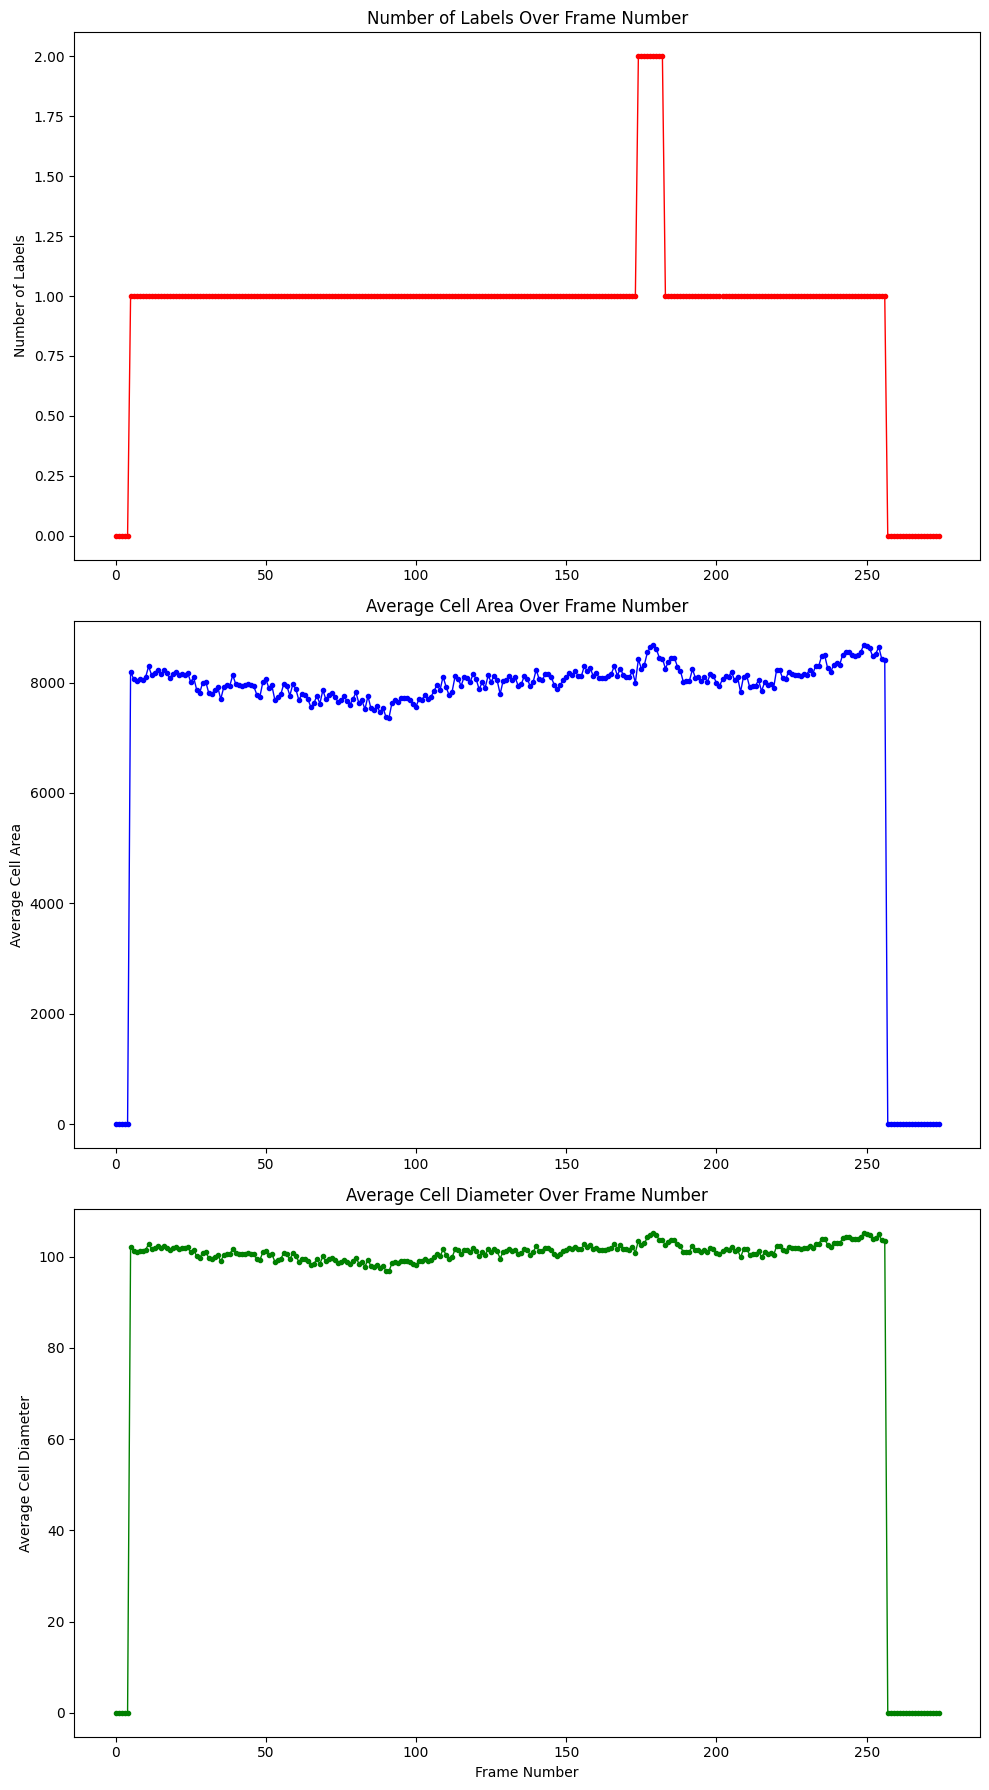

In [24]:
import matplotlib.pyplot as plt

# Lists to store data for each frame
num_labels_list = []
avg_area_list = []
avg_diameter_list = []

# Iterate through each labeled TIFF file
for image_name, frame_regionprops_list in regionprops_dict.items():
    for frame, region_props in frame_regionprops_list.items():
        # Calculate the number of labels
        num_labels = len(region_props)
        num_labels_list.append(num_labels)

        # Calculate average cell area and diameter
        total_area = sum(prop["area"] for prop in region_props)
        avg_area = total_area / num_labels if num_labels > 0 else 0
        avg_area_list.append(avg_area)

        total_diameter = sum(prop["equivalent_diameter"] for prop in region_props)
        avg_diameter = total_diameter / num_labels if num_labels > 0 else 0
        avg_diameter_list.append(avg_diameter)

# Get frame numbers (inner keys)
frame_numbers = list(regionprops_dict['trap_1_all_frames_series'].keys())

# Plotting
plt.figure(figsize=(10, 18))

# Plot Number of Labels
plt.subplot(3, 1, 1)
plt.plot(frame_numbers, num_labels_list[:len(frame_numbers)], marker='o', linestyle='-', markersize=3, linewidth=1, color='red')
plt.ylabel('Number of Labels')
plt.title('Number of Labels Over Frame Number')

# Plot Average Cell Area
plt.subplot(3, 1, 2)
plt.plot(frame_numbers, avg_area_list[:len(frame_numbers)], marker='o', linestyle='-', markersize=3, linewidth=1, color='blue')
plt.ylabel('Average Cell Area')
plt.title('Average Cell Area Over Frame Number')

# Plot Average Cell Diameter
plt.subplot(3, 1, 3)
plt.plot(frame_numbers, avg_diameter_list[:len(frame_numbers)], marker='o', linestyle='-', markersize=3, linewidth=1, color='green')
plt.xlabel('Frame Number')
plt.ylabel('Average Cell Diameter')
plt.title('Average Cell Diameter Over Frame Number')

plt.tight_layout()
plt.show()


### TRACKING!

In [7]:
from deepcell_tracking import CellTracker

# Step 1: Load Image Data (X)
X_path = Path(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Cropped_traps_directory\trap_3_all_frames_series.tiff")
X = tifffile.imread(X_path)

# Step 2: Load Labels or Segmentations (y)
y_path = Path(r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted_2\Labels_directory\trap_3_all_frames_series.tiff")
y = tifffile.imread(y_path)


# X and y are the time-sequence data and their corresponding segmentations (labels), respectively.
# model is a deepcell-tf tracking model.
tracker = CellTracker(X, y, model)

tracker.track_cells()  # runs in place, builds tracks

# Save all tracked data and lineage files to a .trk file
tracker.dump('C:/Users/micha/Desktop/MM_data_Pipeline_results_all/MM_pipeline_results_tiff_file_converted_2/results_tracking.trk')

# Open the track file
from deepcell_tracking.utils import load_trks

data = load_trks('C:/Users/micha/Desktop/MM_data_Pipeline_results_all/MM_pipeline_results_tiff_file_converted_2/results_tracking.trk')

lineage = data['lineages']  # linage information
X = data['X']  # raw X data
y = data['y']  # tracked y data

NameError: name 'model' is not defined